# Step1: Alistamiento del Ambiente

In [31]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

##%matplotlib widget
##%matplotlib widget
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

print('version de tf: ', tf.__version__)

from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

version de tf:  2.10.0


# Step2: Funciones Preparacion de DATA

In [32]:
def clean_data(series):
    """Fills missing values. 
    
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
        
    return series_filled
        
    
def min_max_scale(dataframe):
    """ Applies MinMax Scaling
    
        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)

# Step3: Carga y limpieza de los datos 

* Funcion para el cargue de datos , las columnas que se esperan trabajar dentro del modelo son : ['time','total load actual', 'price actual'],

In [33]:
path_local='Datos/'
file_kEner='energy_dataset.csv'

def load_data(col=None, path=path_local+file_kEner, verbose=True):
    df = pd.read_csv(path)
    if col is not None:
        df = df[col]
    if verbose:
        print(df.head())
    return df

#print("Multivariate Sample")
#multivar_df = load_data(['time','total load actual', 'price actual'], verbose=True)

#       ¡¡¡ Vistazo inicial de Data !!!

                        time  total load actual  price actual
0  2015-01-01 00:00:00+01:00            25385.0         65.41
1  2015-01-01 01:00:00+01:00            24382.0         64.92
2  2015-01-01 02:00:00+01:00            22734.0         64.48
3  2015-01-01 03:00:00+01:00            21286.0         59.32
4  2015-01-01 04:00:00+01:00            20264.0         56.04


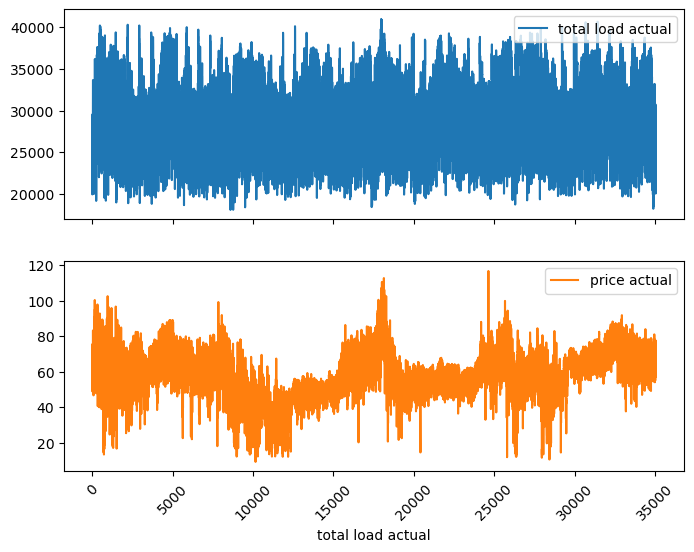

In [79]:
multivar_df = load_data(['time','total load actual', 'price actual'], verbose=True)
multivar_df.plot(subplots=True, rot=45, xlabel='total load actual')
plt.show()

* funcion que tiene el proposito de convertir la fecha que se encuentra en formato UTC dejarla en formato datetime y identificar:
    * Hora
    * Dia de la semana 
    * Mes 

In [34]:
def make_time_features(series):
    
    #convert series to datetimes
    times = series.apply(lambda x: x.split('+')[0])
    datetimes = pd.DatetimeIndex(times)
    
    hours = datetimes.hour.values
    day = datetimes.dayofweek.values
    months = datetimes.month.values
    
    hour = pd.Series(hours, name='hours')
    dayofw = pd.Series(day, name='dayofw')
    month = pd.Series(months, name='months')
    
    return hour, dayofw, month

# hour, day, month = make_time_features(multivar_df.time)
# print("Hours")
# print(hour.head())
# print("Day of Week")
# print(day.head())
# print("Months")
# print(month.head())
# print("Information")
# print(multivar_df.head())

Funcion que se encarga de armar los paquetes para 
* Pruebas 
* Entrenamiento 
* Validacion 
Tener en cuenta que la data esta en intervalos de 1 hora 
por defecto la longitud del conjunto de pruebas es de 8760 horas/registros que corresponden a 1 año de dartos 24*365
Hace 

In [35]:
def divide_data(series, train_fraq, test_len=8760):
    """Splits input series into train, val and test.
    
        Default to 1 year of test data.
    """
    #slice the last year of data for testing 1 year has 8760 hours
    test_slice = len(series)-test_len

    test_data = series[test_slice:]
    train_val_data = series[:test_slice]

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    
    return train_data, val_data, test_data


#multivar_df = clean_data(multivar_df)

#add hour and month features
#hours, day, months = make_time_features(multivar_df.time)
#multivar_df = pd.concat([multivar_df.drop(['time'], axis=1), hours, day, months], axis=1)

#scale
#multivar_df = min_max_scale(multivar_df)
#train_multi, val_multi, test_multi = split_data(multivar_df, train_fraq=0.65, test_len=8760)
#print("Multivarate Datasets")
#print(f"Train Data Shape: {train_multi.shape}")
#print(f"Val Data Shape: {val_multi.shape}")
#print(f"Test Data Shape: {test_multi.shape}")
#print(f"Nulls In Train {np.any(np.isnan(train_multi))}")
#print(f"Nulls In Validation {np.any(np.isnan(val_multi))}")
#print(f"Nulls In Test {np.any(np.isnan(test_multi))}")

* En esta funcion se busca crear conjuntos de datos para sr procesados por  tensorflow 
  Este es un vector de pasos de tiempo pasados (n_pasos) que se utiliza para predecir un vector objetivo de pasos futuros (n_horizonte). 
  El siguiente ejemplo muestra el resultado de n_steps = 72 y n_horizon = 24 y las 5 funciones. 
  Entonces usamos los últimos 3 días (72 horas) para predecir el día siguiente (después de 24 horas).

La forma resultante para X será (tamaño de lote, n_pasos, características) e Y será (tamaño de lote, n_horizonte, características).

In [36]:
def ventana_datos(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    """ Create a windowed tensorflow dataset
    
    """

    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon
    
    #expand dimensions to 3D to fit with LSTM inputs
    #creat the inital tensor dataset
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    
    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    
    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)    
    
    #create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

#tf.random.set_seed(42)

#n_steps = 72
#n_horizon = 24
#batch_size = 1
#shuffle_buffer = 100


#ds = ventana_datos(train_multi, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True)

#print('Example sample shapes')
#for idx,(x,y) in enumerate(ds):
#    print("x = ", x.numpy().shape)
#    print("y = ", y.numpy().shape)
#    break

* Funcion que se encarga de terminar el alisatamiento del set de datos de informacion 
    * Generacion de la semilla en tensorflow
    * Arma los set de dato dependiendo si el analisis va a ser multivariado o de un solo feature
    * Hace estandarizacion de los datos con la funcion de minmax
    * Hace el llamado a una funcion por ventana que se encarga de recorrer el set de datos y alistar los tensores para el entrenamiento

In [54]:
def crea_datos (train_fraq=0.65, 
                  n_steps=24*30, 
                  n_horizon=24, 
                  batch_size=256, 
                  shuffle_buffer=500, 
                  expand_dims=False, 
                  multi_var=False):
    """If multi variate then first column is always the column from which the target is contstructed.
    """
    
    tf.random.set_seed(23)
    
    if multi_var:
        data = load_data(col=['time', 'total load actual', 'price actual'])
        hours, day, months = make_time_features(data.time)
        data = pd.concat([data.drop(['time'], axis=1), hours, day, months], axis=1)
    else:
        data = load_data(col=['time','total load actual'])
        hours, day, months = make_time_features(data.time)
        data = pd.concat([data.drop(['time'], axis=1), hours, day, months], axis=1)
        
    data = clean_data(data)
    
    if multi_var:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)
    else:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)
        
    
    train_data, val_data, test_data = divide_data(data, train_fraq=train_fraq, test_len=8760)
    
    train_ds = ventana_datos (train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds   = ventana_datos (val_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    test_ds  = ventana_datos (test_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    
    
    #print(f"Prediction lookback (n_steps): {n_steps}")
    #print(f"Prediction horizon (n_horizon): {n_horizon}")
    #print(f"Batch Size: {batch_size}")
    #print("Datasets:")
    #print(train_ds.element_spec)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = crea_datos(multi_var=True)

                        time  total load actual  price actual
0  2015-01-01 00:00:00+01:00            25385.0         65.41
1  2015-01-01 01:00:00+01:00            24382.0         64.92
2  2015-01-01 02:00:00+01:00            22734.0         64.48
3  2015-01-01 03:00:00+01:00            21286.0         59.32
4  2015-01-01 04:00:00+01:00            20264.0         56.04


# Step4: Alistamiento y configuracion del Modelo

### Los parametros por defecto son :
 * n_steps: Ultimos 30 dias
 * n_horizon: Proximas 24 horas
 * learning rate: 3e-4 ( 3X10-4)

In [45]:
def get_params(multivar=False):
    lr = 3e-4
    n_steps=24*30
    n_horizon=24
    if multivar:
        n_features=5
    else:
        n_features=1
        
    return n_steps, n_horizon, n_features, lr

model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}


def run_model(model_name, model_func, model_configs, epochs,lv_ismultivar):
    
    n_steps, n_horizon, n_features, lr = get_params(multivar=lv_ismultivar)
    train_ds, val_ds, test_ds = crea_datos(n_steps=n_steps, n_horizon=n_horizon, multi_var=lv_ismultivar)
    ## hace el llamado al modelo lstm_model, con los parametros por defecto generados por la funcion : get_params
    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

# Step5: Definicion del Modelo 

In [39]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True,name= 'LSTM_72'),
        LSTM(48, activation='relu', return_sequences=False,name= 'LSTM_48'),
        Flatten(name= 'Flatten'),
        Dropout(0.3,name= 'Dropout1'),
        Dense(128, activation='relu',name= 'Dense1'),
        Dropout(0.3,name= 'Dropout2'),
        Dense(n_horizon,name= 'DenseFinal')
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

In [47]:
lstm = lstm_model(*get_params(multivar=False))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_72 (LSTM)              (None, 720, 72)           21312     
                                                                 
 LSTM_48 (LSTM)              (None, 48)                23232     
                                                                 
 Flatten (Flatten)           (None, 48)                0         
                                                                 
 Dropout1 (Dropout)          (None, 48)                0         
                                                                 
 Dense1 (Dense)              (None, 128)               6272      
                                                                 
 Dropout2 (Dropout)          (None, 128)               0         
                                                                 
 DenseFinal (Dense)          (None, 24)                3096   

# Step6: Entrenamiento Del Modelo 

In [56]:
run_model("lstm", lstm_model, model_configs, epochs=20,lv_ismultivar=True)

                        time  total load actual  price actual
0  2015-01-01 00:00:00+01:00            25385.0         65.41
1  2015-01-01 01:00:00+01:00            24382.0         64.92
2  2015-01-01 02:00:00+01:00            22734.0         64.48
3  2015-01-01 03:00:00+01:00            21286.0         59.32
4  2015-01-01 04:00:00+01:00            20264.0         56.04
Epoch 1/20


C:\Users\john.camargo\Anaconda3\envs\envProyRead\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 13s 4s/step - loss: 0.1127 - mae: 0.4315 - val_loss: 0.1184 - val_mae: 0.4424
Epoch 2/20
3/3 [==============================] - 12s 4s/step - loss: 0.0983 - mae: 0.3967 - val_loss: 0.1029 - val_mae: 0.4020
Epoch 3/20
3/3 [==============================] - 13s 4s/step - loss: 0.0780 - mae: 0.3394 - val_loss: 0.0753 - val_mae: 0.3215
Epoch 4/20
3/3 [==============================] - 14s 4s/step - loss: 0.0574 - mae: 0.2751 - val_loss: 0.0549 - val_mae: 0.2692
Epoch 5/20
3/3 [==============================] - 14s 4s/step - loss: 0.0430 - mae: 0.2366 - val_loss: 0.0497 - val_mae: 0.2559
Epoch 6/20
3/3 [==============================] - 14s 4s/step - loss: 0.0317 - mae: 0.2006 - val_loss: 0.0442 - val_mae: 0.2416
Epoch 7/20
3/3 [==============================] - 14s 4s/step - loss: 0.0264 - mae: 0.1833 - val_loss: 0.0429 - val_mae: 0.2375
Epoch 8/20
3/3 [==============================] - 15s 5s/step - loss: 0.0222 - mae: 0.1668 - val_loss: 0.0460 - val

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

# Step7- Evaluacion del Entrenamiento

La curva de pérdidas es estable.
El modelo muestra una curva de validación plana mientras que el entrenamiento continúa declinando. 

Los modelos LSTM  se espera que funcione bien debido a su capacidad para aprender y recordar tendencias más largas en los datos.


In [83]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Pérdida entrenamiento')
    plt.plot(epochs, val_loss, 'r', label='Pérdida validación')
    plt.title(title)
    plt.xlabel('epochs')
    plt.legend()

    plt.show()

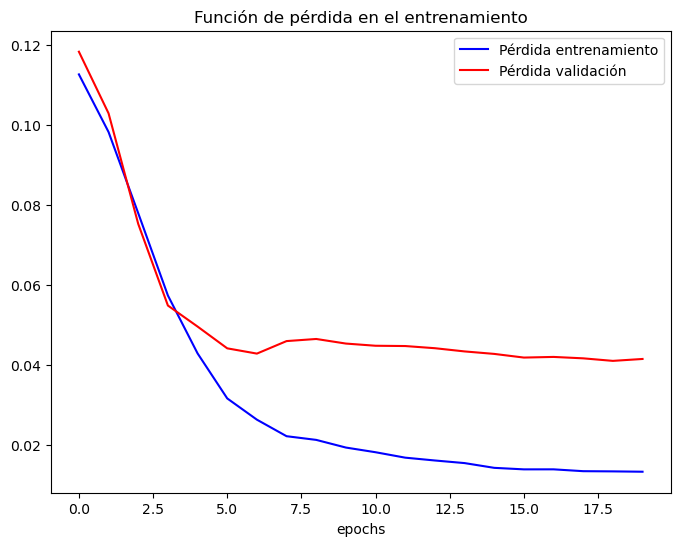

In [84]:
plot_train_history(val['history'],
                   'Función de pérdida en el entrenamiento')

# Step8 Visualizacion de las Predicciones

### Se trazaron intervalos de 24 horas reales y pronosticados. A continuación se muestran los primeros 14 días de predicciones. 

In [101]:
model_configs

{'lstm': {'model': <keras.engine.sequential.Sequential at 0x153d1545460>,
  'history': <keras.callbacks.History at 0x153d162bb20>,
  'test_ds': <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>}}

2/2 [==============================] - 1s 181ms/step
First Two Weeks of Predictions


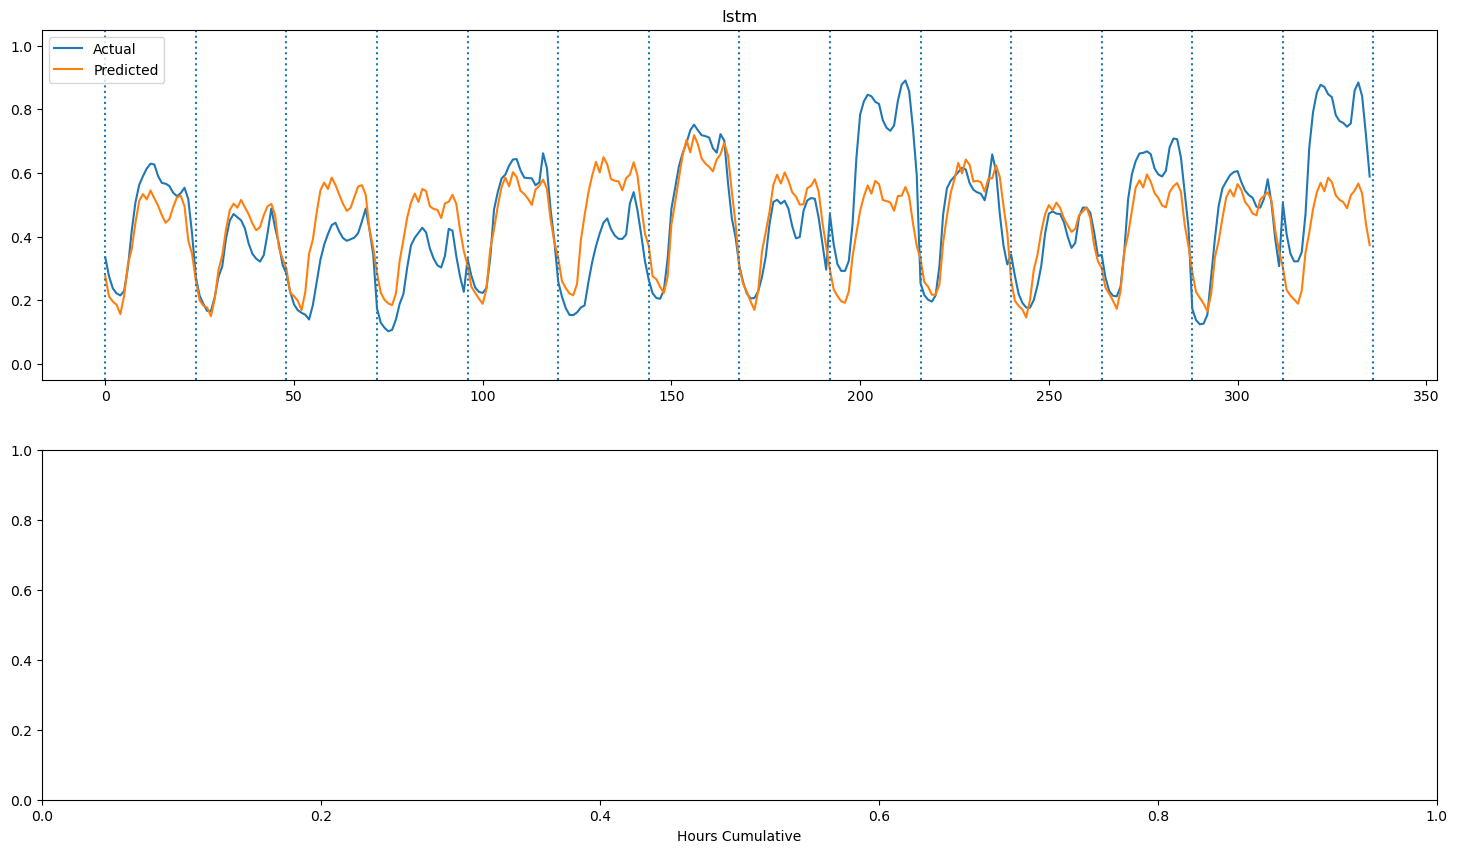

In [120]:
fig, axs = plt.subplots(2, 1, figsize=(18, 10))
#fig, axs = plt.subplots(1) #figsize=(18, 10)
days = 14

vline = np.linspace(0, days*24, days+1)

for (key, val), ax in zip(model_configs.items(), axs):

    test = val['test_ds']
    preds = val['model'].predict(test)

    xbatch, ybatch = iter(test).get_next()

    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted', transform = ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])

plt.xlabel("Hours Cumulative")
print('First Two Weeks of Predictions')